# Bagging of classifiers

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, I show how to interpret a bag of classifiers, but the same goes for regressors.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

### Load data

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic_trees.csv')

df.head()

,pclass,sibsp,parch,sex,embarked,cabin,survived
0,1,0,0,0,0,0,1
1,1,1,2,1,0,1,1
2,1,1,2,0,0,1,0
3,1,1,2,1,0,1,0
4,1,1,2,0,0,1,0


### Split data

In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

X_train.shape, X_test.shape

((1112, 6), (197, 6))

## Bagging logistic regression

In [4]:
# fit model

bag = BaggingClassifier(
    estimator=LogisticRegression(),
    n_estimators=3,
    random_state=3,
)

bag.fit(X_train, y_train)

BaggingClassifier(estimator=LogisticRegression(), n_estimators=3,
                  random_state=3)

In [5]:
# Accuracy in train set
bag.score(X_train, y_train)

0.783273381294964

In [6]:
# Accuracy in test set

bag.score(X_test, y_test)

0.8477157360406091

The model correctly predicts ~78% of the outcomes.

In [7]:
baseline = 1 - y_train.mean()
baseline

0.6214028776978417

A baseline model that selects the majority class (not survived) has 62% accuracy. 

Our model has ~80%, which means that is better than the baseline, that is, better than just predicting the majority class.

## Global explanations - feature importance

The importance in logistic regression is given by the coefficients. If we bag the models, then the overall importance is the average of the coefficients of the models in the bag.

In [8]:
# importance based on each model

# Let's take the importance derived by each single logistic regression

global_exp = pd.concat([
    pd.Series(bag.estimators_[0].coef_[0]),
    pd.Series(bag.estimators_[1].coef_[0]),
    pd.Series(bag.estimators_[2].coef_[0]),
], axis=1,
)

global_exp.columns = ["logit_1", "logit_2", "logit_3"]
global_exp.index = bag.feature_names_in_

# Now we calculate the mean importance, by taking the 
#average of the coefficients
global_exp["importance"] = global_exp.mean(axis=1)

global_exp

,logit_1,logit_2,logit_3,importance
pclass,-0.726388,-0.902123,-0.910289,-0.846267
sibsp,-0.263004,-0.226251,-0.273635,-0.254297
parch,0.133385,0.043675,0.114370,0.097143
sex,-2.429721,-2.775291,-2.563913,-2.589642
embarked,-0.036631,0.202995,0.147538,0.104634
cabin,-0.077258,-0.056336,-0.031078,-0.054891


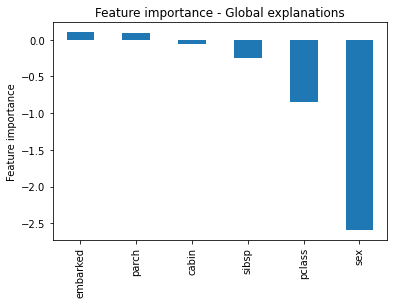

In [9]:
global_exp["importance"].sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

Gender is the most important feature, and it drastically decreases the probability of survival in the titanic.

## Local explanations

The local explanation of the final output takes the average local explanation obtained from each model.

In [10]:
X_test.head()

,pclass,sibsp,parch,sex,embarked,cabin
201,1,0,0,1,0,2
115,1,1,4,1,0,1
255,1,0,0,0,1,0
1103,3,4,1,1,0,5
195,1,0,0,0,0,0


In [11]:
obs = 201

X_test.loc[obs]

pclass      1
sibsp       0
parch       0
sex         1
embarked    0
cabin       2
Name: 201, dtype: int64

In [12]:
# The coefficients of each logit

global_exp[['logit_1', 'logit_2', 'logit_3']]

,logit_1,logit_2,logit_3
pclass,-0.726388,-0.902123,-0.910289
sibsp,-0.263004,-0.226251,-0.273635
parch,0.133385,0.043675,0.114370
sex,-2.429721,-2.775291,-2.563913
embarked,-0.036631,0.202995,0.147538
cabin,-0.077258,-0.056336,-0.031078


In [13]:
# log(Odds) contribution of each feature

effect = global_exp[['logit_1', 'logit_2', 'logit_3']].T * X_test.loc[obs]

effect

,pclass,sibsp,parch,sex,embarked,cabin
logit_1,-0.726388,-0.0,0.0,-2.429721,-0.0,-0.154517
logit_2,-0.902123,-0.0,0.0,-2.775291,0.0,-0.112671
logit_3,-0.910289,-0.0,0.0,-2.563913,0.0,-0.062156


In [14]:
# Mean log(Odds) contribution of each feature

effect.mean()

pclass     -0.846267
sibsp       0.000000
parch       0.000000
sex        -2.589642
embarked    0.000000
cabin      -0.109781
dtype: float64

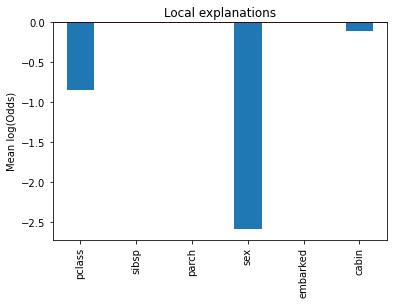

In [15]:
# First sample

effect.mean().plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Mean log(Odds)")
plt.title("Local explanations")
plt.show()

In this sample, the class decreases the probability of survival quite dramatically.

In [16]:
obs = 255

X_test.loc[obs]

pclass      1
sibsp       0
parch       0
sex         0
embarked    1
cabin       0
Name: 255, dtype: int64

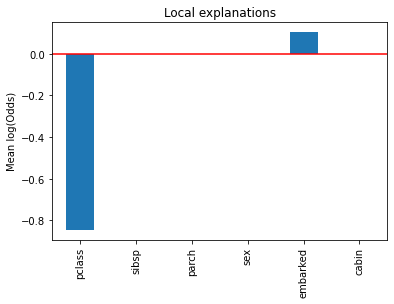

In [17]:
# Third sample
obs = 255

effect = global_exp[['logit_1', 'logit_2', 'logit_3']].T * X_test.loc[obs]

effect.mean().plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Mean log(Odds)")
plt.title("Local explanations")
plt.show()

In this observation, pclass decreases the probability of survival. A priori gender does not seem to contribute, but remember that logistic regression is a linear model, and the reference category is female. So when gender is male, the coefficient indicates the change in survival odds respect to being female. But in this case the observation is female, which is the reference category.

As we see, no explanation is perfect. Logistic regression explanations are less intuitive than decision tree explanations.